In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import pickle
import torch
import torch.nn as nn
import time
import sympy as sy
import imageio
import glob 

# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

# Import helper classes/functions
from network_helper import Net, PI_DON_reg
from data_helper import pde_exact
from misc_helper import animation, training_results, knw_log, competitive_plot
from knw_helper import coeff, K_n_width

# Step 1: Load in and visualize data

In [2]:
PDE = 'poisson'

with open(parent_path + '\\data\\' + 'poisson1D_dict.pickle', 'rb') as handle:
    poisson1D_dict = pickle.load(handle)

u_ls = np.array(poisson1D_dict['u'])
f_ls = np.array(poisson1D_dict['f'])
c_ls = np.array(poisson1D_dict['c'])
x = poisson1D_dict['x']
xb = np.array([-1,1])

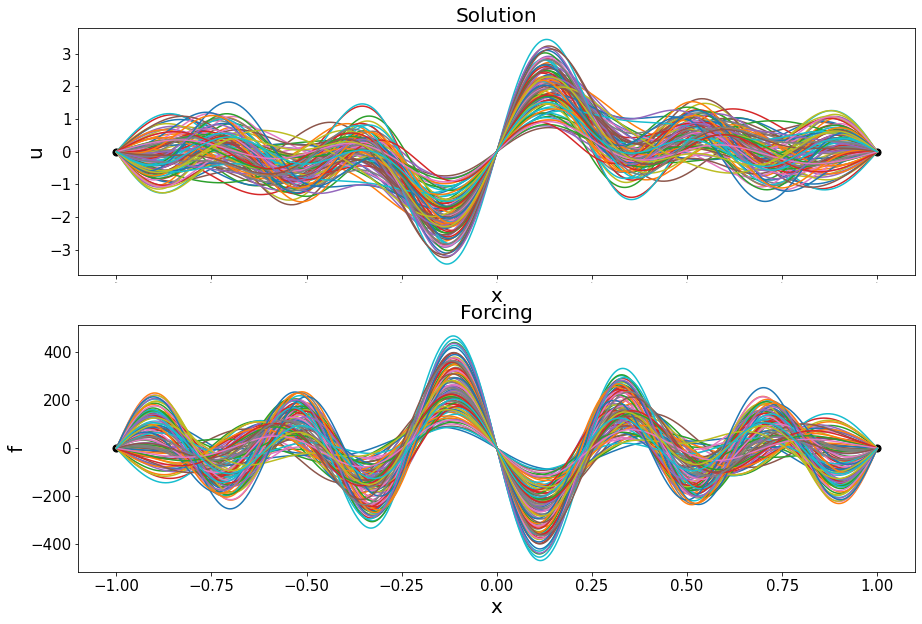

In [3]:
# Plot
plt.figure(figsize = (15,10))
for i in range(len(u_ls)):
    plt.subplot(2,1,1)
    plt.plot(x, u_ls[i])
    plt.subplot(2,1,2)
    plt.plot(x, f_ls[i])
    
plt.subplot(2,1,1)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Solution', fontsize=20);
plt.xticks(fontsize=0); plt.yticks(fontsize=15); 
plt.subplot(2,1,2)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('f', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Forcing', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15);

# Step 2: Initialize and train multitask model

In [4]:
input_y_b = []
input_u = []
physicsInformed_u = []
input_y_f = []
output_b = []

input_y_b = xb
input_y_f = x[:][1:-1]

for i in range(len(u_ls)):
    input_u.append(c_ls[i][:]) # Subsample because dimensionality reduction in branch (512 -> 20) is too much without more hidden layers
    physicsInformed_u.append(f_ls[i][:])
    output_b.append([u_ls[i][0], u_ls[i][-1]]) 
    
# PI-DON
number_of_cases = 20
branch_layers = [5,20,20]
trunk_layers = [1,20,20]
act = 'tanh'; verbose = 1; epoch = 1000

torch.manual_seed(0); np.random.seed(0)
model_pidon = PI_DON_reg(input_u, physicsInformed_u, input_y_f, input_y_b, output_b, branch_layers, trunk_layers, number_of_cases, act, PDE)

G:\My Drive\Research\Notebook files\n-width\K-n-width\Version 2\Version 3\source\network_helper.py:461: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  self.input_u = torch.tensor(input_u, dtype = torch.float32, requires_grad=True)


In [5]:
print('PI-DON')
start_time = time.time()
# Adam training
print('Train Adam:')
model_pidon.train(epoch)
# LBFGS training
print('Train L-BFGS:')
# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 5000; max_eval = None; tolerance_grad = -1; tolerance_change = -1; history_size = 50;
model_pidon.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time            
print('Training time: %.4f' % (elapsed))

PI-DON
Train Adam:
Epoch:  0
loss:267034
Kwn loss: 451.122
Epoch:  100
loss:266683
Kwn loss: 183.845
Epoch:  200
loss:257761
Kwn loss: 184.895
Epoch:  300
loss:107775
Kwn loss: 188.95
Epoch:  400
loss:69527
Kwn loss: 176.968
Epoch:  500
loss:45328.4
Kwn loss: 191.686
Epoch:  600
loss:21549.7
Kwn loss: 178.995
Epoch:  700
loss:9241.74
Kwn loss: 150.832
Epoch:  800
loss:6559.99
Kwn loss: 152.135
Epoch:  900
loss:4769.41
Kwn loss: 151.421
Knw: tensor(59.8751)
Train L-BFGS:
L-BFGS iter:  500
loss:528.616
Kwn loss: 159.292
L-BFGS iter:  1000
loss:253.213
Kwn loss: 124.6
L-BFGS iter:  1500
loss:187.049
Kwn loss: 120.062
L-BFGS iter:  2000
loss:140.888
Kwn loss: 103.898
L-BFGS iter:  2500
loss:122.117
Kwn loss: 89.6686
L-BFGS iter:  3000
loss:106.783
Kwn loss: 79.9241
L-BFGS iter:  3500
loss:92.11
Kwn loss: 69.3733
L-BFGS iter:  4000
loss:83.8167
Kwn loss: 65.1165
L-BFGS iter:  4500
loss:78.0697
Kwn loss: 62.037
L-BFGS iter:  5000
loss:73.5892
Kwn loss: 61.5752
Training time: 357.2686


# Step 3: Visualize training results

Relative L2 Error (mean): 0.08185809151463416
Relative L2 Error (std): 0.06223053141994475
2-Norm Error (mean): 1.426488380373276
2-Norm Error (std): 0.8592839366514232


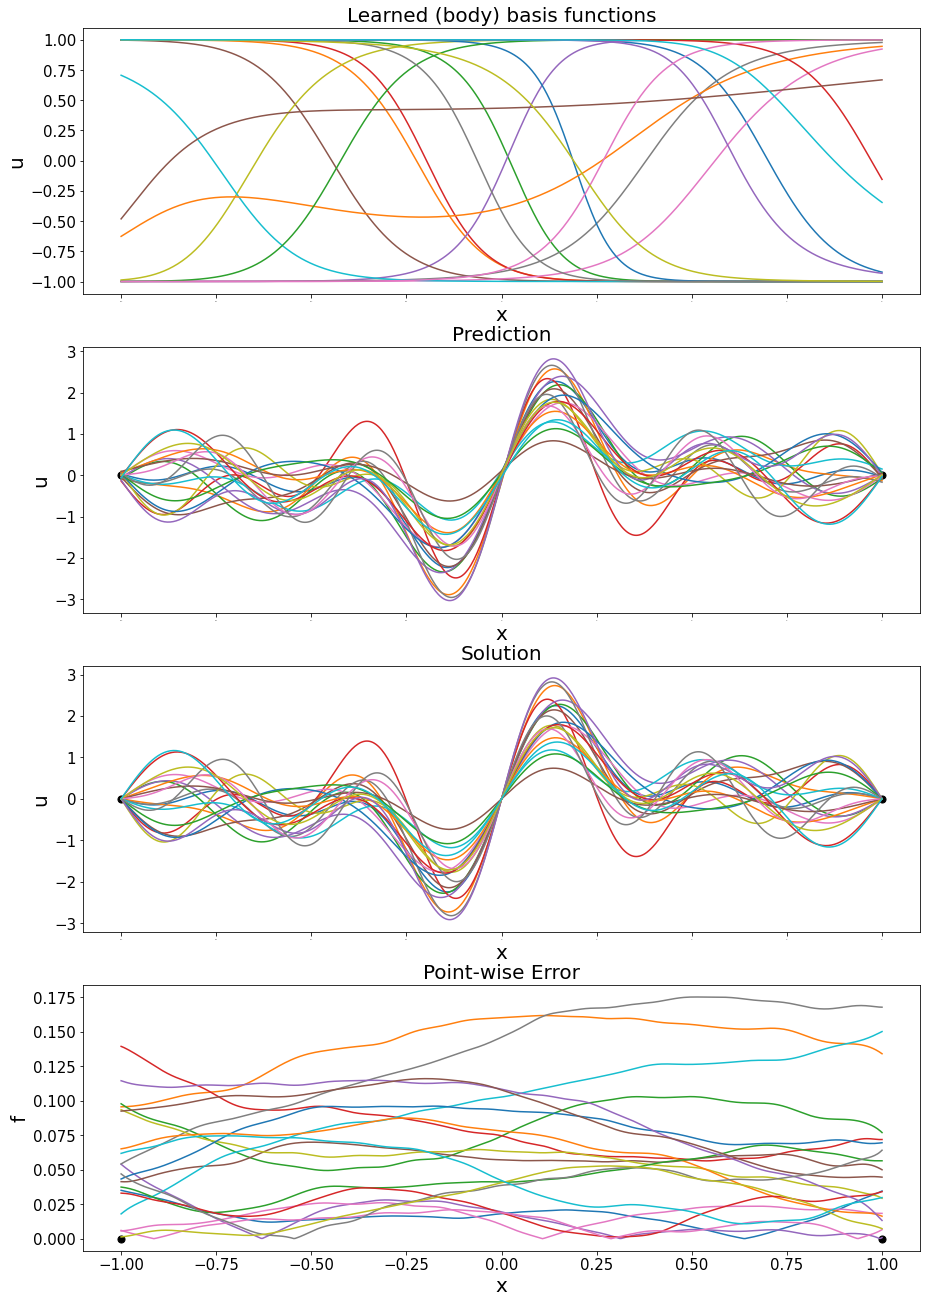

In [6]:
# Predictions
pidon_u_pred, basis, coeff = model_pidon.pred(input_u, x)
l2_error_ls = []; norm2_ls = []
for i in range(number_of_cases):
    pred = pidon_u_pred[i].detach().numpy().flatten()
    l2_error_ls.append(np.linalg.norm(u_ls[i]-pred.flatten(), 2)/np.linalg.norm(u_ls[i], 2))
    norm2_ls.append(np.linalg.norm(u_ls[i]-pred.flatten(), 2))
print('Relative L2 Error (mean):', np.mean(np.array(l2_error_ls)))
print('Relative L2 Error (std):', np.std(np.array(l2_error_ls)))
print('2-Norm Error (mean):', np.mean(np.array(norm2_ls)))
print('2-Norm Error (std):', np.std(np.array(norm2_ls)))

# Plot
plt.figure(figsize = (15,22.5))
plt.subplot(4,1,1)
for i in range(trunk_layers[-1]):
    plt.plot(x, basis.detach().numpy()[:,i])

for i in range(number_of_cases):
    plt.subplot(4,1,2)
    plt.plot(x, pidon_u_pred[i].detach().numpy().flatten())
    plt.subplot(4,1,3)
    plt.plot(x, u_ls[i])
    plt.subplot(4,1,4)
    plt.plot(x, abs(u_ls[i]-pidon_u_pred[i].detach().numpy().flatten()))

plt.subplot(4,1,1)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Learned (body) basis functions', fontsize=20);
plt.xticks(fontsize=0); plt.yticks(fontsize=15); 
plt.subplot(4,1,2)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Prediction', fontsize=20);
plt.xticks(fontsize=0); plt.yticks(fontsize=15); 
plt.subplot(4,1,3)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Solution', fontsize=20);
plt.xticks(fontsize=0); plt.yticks(fontsize=15);
plt.subplot(4,1,4)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('f', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Point-wise Error', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15);

# Step 4: Compute K n-width metric

In [8]:
# Competative optimization
exact = pde_exact() # Needed for error estimate
solution_basis = np.array([np.sin(x*np.pi), np.sin(2*x*np.pi), np.sin(3*x*np.pi), np.sin(4*x*np.pi), np.sin(5*x*np.pi)])
model_basis = basis.detach().numpy().T

In [9]:
# Create bi-optimization problem
torch.manual_seed(0); np.random.seed(0)
verbose = 0; adam_lr = 0.001; animate = 0;  comp_plot = 1
model_name = 'don_tanh_reg'
KnW = K_n_width(solution_basis, model_basis, adam_lr, verbose, exact, 0, None, None)

In [10]:
# Training and animation
epochs = 5000
gif_num = 100; subepoch = int(epochs/gif_num)
log = knw_log()

fig_num = 0
for i in range(gif_num):
    u_c_optimized, u_W1_optimized, u_c_coeff, u_W1_coeff = KnW.solution()
    log.add(x, u_c_optimized, u_W1_optimized)
    if animate == 1:
        animation(path, model_name, fig_num, x, u_c_optimized, u_W1_optimized)
    KnW.train_adam(subepoch)
    fig_num += 1

knw_metric = KnW.metric().detach().numpy()
knw_l2_error = np.linalg.norm(u_c_optimized.detach().numpy()-u_W1_optimized.detach().numpy(), 2)/np.linalg.norm(u_c_optimized.detach().numpy(), 2)
print('KnW Metric:', knw_metric)
print('KnW Rel L2 Error:', knw_l2_error)

KnW Metric: 6.133737685075432
KnW Rel L2 Error: 0.20834227752083853


In [11]:
if animate == 1:
    impath = glob.glob(path + '\\figures\\' + model_name + '_animate_' + '*.png')
    images = [];
    for filename in impath:
        images.append(imageio.imread(filename))
    imageio.mimsave(path + '\\figures\\' + model_name + '.mp4', images, macro_block_size = 1)

if comp_plot == 1:
    competitive_plot(path, model_name, log.report(), len(log.report())-1)

In [12]:
# Save data
log_dict = {'l2_error_ls': l2_error_ls, 'knw_l2_error': knw_l2_error}

with open(path + '\\log\\' + model_name + '_log_dict.pickle', 'wb') as handle:
    pickle.dump(log_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)